# Augmentation on images

In [1]:
!pip install mycolorpy --quiet
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/M_DV_V2022


In [40]:
import matplotlib.pyplot as plt
import numpy as np
from cv2 import Sobel, Laplacian, watershed
import cv2 as cv

import seaborn as sns

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mycolorpy import colorlist as mcp


from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input

from unet_detection.models.vanilla_unet import vanilla_unet

## Load data

In [3]:
X_train = np.load("data/spec_lib/X_data.npy") 
#X_70_train = np.load("data/spec_lib/X_70_data.npy")
y_train = np.load("data/spec_lib/y_data.npy")

X_val = np.load("data/spec_lib/X_data_val.npy")
#X_70_val = np.load("data/spec_lib/X_70_data_val.npy")
y_val = np.load("data/spec_lib/y_data_val.npy")

X_test = np.load("data/spec_lib/X_data_test.npy")
#X_70_test = np.load("data/spec_lib/X_70_data_test.npy")
y_test = np.load("data/spec_lib/y_data_test.npy")

In [4]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [5]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(150, 128, 128, 6)
(20, 128, 128, 6)
(50, 128, 128, 6)


## Augmentation on data

In [6]:
X_train[X_train<0] = 0
X_train[X_train>10000] = 10000

X_val[X_val<0] = 0
X_val[X_val>10000] = 10000

In [22]:
def augment_brightness(X,y, n=10):
    datagen = ImageDataGenerator()
    # Xshape = (n, x,y,c)
    brigthness = [0.6, 0.7, 0.8, 0.9, 1.1, 1.2, 1.3, 1.4, 1.5]
    list_of_indx = np.linspace(0, X.shape[0]-1, X.shape[0], dtype=int)

    indx = np.random.choice(list_of_indx, size=n, replace=False)
    brigt = np.random.choice(brigthness, size=n)
    img = []
    img_y = []

    for i,b in zip(indx, brigt):
      temp_img = datagen.apply_transform(X[i], {"horizontal_flip":True})
      img.append(temp_img * b)
      img_y.append(y[i])

    img = np.array(img)
    img_y = np.array(img_y)
    return img, img_y

In [23]:
X_train_aug, y_train_aug = augment_brightness(X_train,y_train, n=20)

In [24]:
y_train_aug.shape

(20, 128, 128, 6)

In [25]:
X = np.append(X_train, X_train_aug, axis=0)
y = np.append(y_train, y_train_aug, axis=0)

In [26]:
X.shape

(170, 128, 128, 399)

## Set up unet and train

In [27]:
u = vanilla_unet()

img1 = Input(shape=(128,128,399))

model = u.get_unet(img1, None, n_classes=6, last_activation='softmax')

model.compile(optimizer='adam',
              loss='categorical_crossentropy')

In [29]:
h = model.fit(X,
              y, 
              validation_data=(X_val,y_val), 
              batch_size=32,
              epochs=100)

Epoch 1/100
6/6 [==============================] - 15s 630ms/step - loss: 1.7507 - val_loss: 545.3548
Epoch 2/100
6/6 [==============================] - 2s 344ms/step - loss: 1.4351 - val_loss: 3040.7339
Epoch 3/100
6/6 [==============================] - 2s 328ms/step - loss: 1.2415 - val_loss: 169.8161
Epoch 4/100
6/6 [==============================] - 2s 331ms/step - loss: 1.1052 - val_loss: 1269.3682
Epoch 5/100
6/6 [==============================] - 2s 329ms/step - loss: 1.0121 - val_loss: 7703.3994
Epoch 6/100
6/6 [==============================] - 2s 328ms/step - loss: 0.9216 - val_loss: 512.1404
Epoch 7/100
6/6 [==============================] - 2s 331ms/step - loss: 0.8455 - val_loss: 307.5934
Epoch 8/100
6/6 [==============================] - 2s 330ms/step - loss: 0.7810 - val_loss: 115.5443
Epoch 9/100
6/6 [==============================] - 2s 329ms/step - loss: 0.7258 - val_loss: 16.3872
Epoch 10/100
6/6 [==============================] - 2s 337ms/step - loss: 0.6749 - val_l

Text(0, 0.5, 'loss')

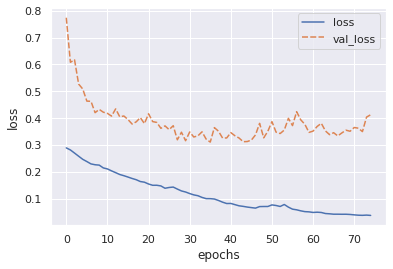

In [35]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][25:]) for key in ['loss', 'val_loss']})
plt.xlabel("epochs"); plt.ylabel("loss")

## Validate data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


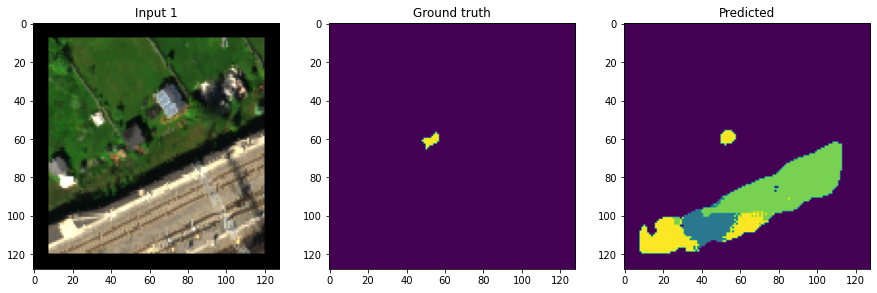

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


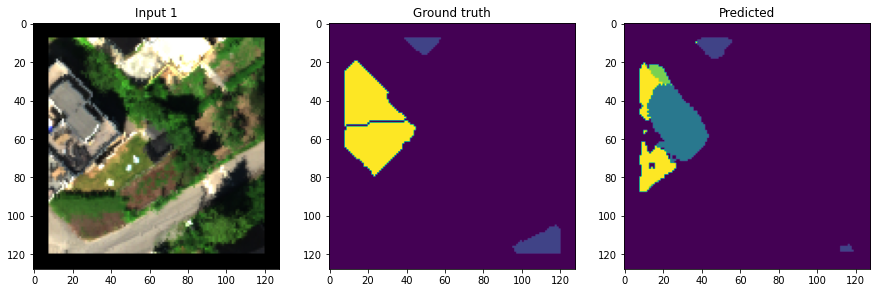

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


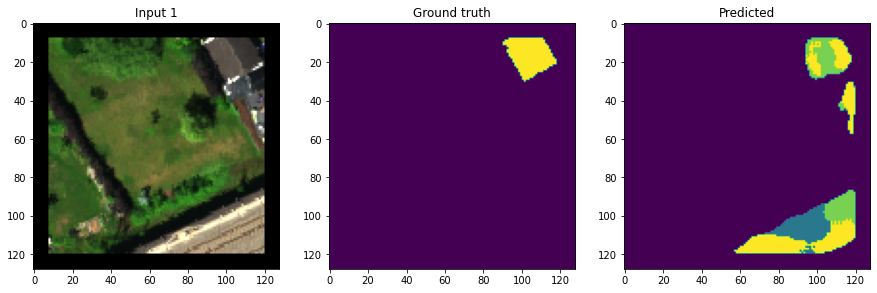

In [48]:
sns.reset_orig()
for _ in range(3):
  x = np.random.randint(X_val.shape[0])
  fig, (ax1,  ax3, ax4) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_val[x:x+1][0][:,:,76],
                        X_val[x:x+1][0][:,:,46],
                        X_val[x:x+1][0][:,:,21]))/2500)
  
  #ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input 1")

  #ax2.imshow(X_val[x:x+1][0][:,:,0:3])
  #ax2.imshow(np.dstack((X_70_val[x:x+1][0][:,:,137],
  #                      X_70_val[x:x+1][0][:,:,194],
  #                      X_70_val[x:x+1][0][:,:,207])))
  #ax2.set_title("Input 2")


  ax3.imshow(y_val[x:x+1].argmax(axis=3)[0])
  ax3.set_title("Ground truth")
  pred = model.predict([X_val[x:x+1]]).argmax(axis=3)[0]
  ax4.imshow(pred)
  ax4.set_title("Predicted")
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


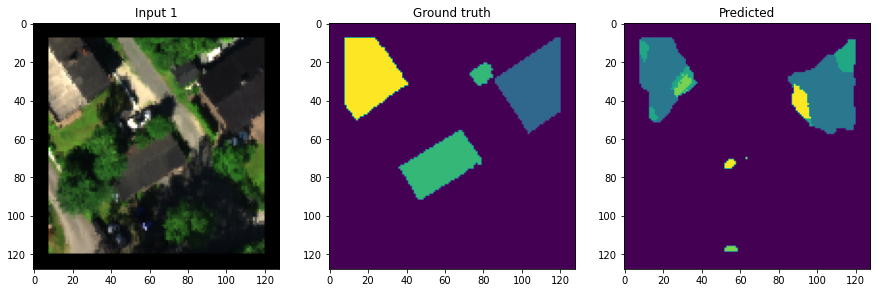

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


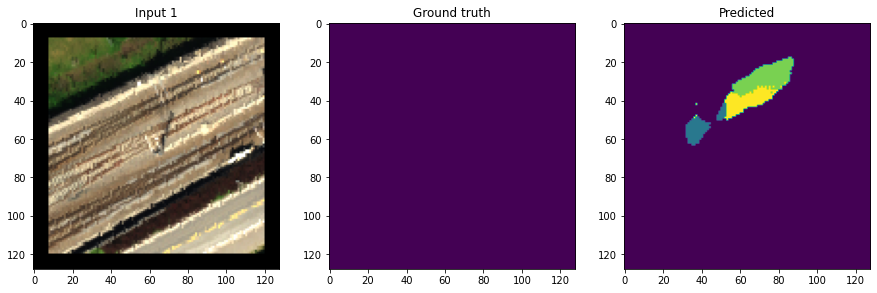

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


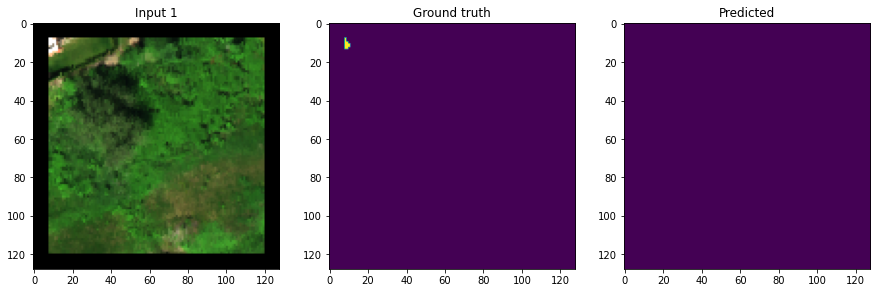

In [49]:
sns.reset_orig()
for _ in range(3):
  x = np.random.randint(X_test.shape[0])
  fig, (ax1,  ax3, ax4) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_test[x:x+1][0][:,:,76],
                        X_test[x:x+1][0][:,:,46],
                        X_test[x:x+1][0][:,:,21]))/2500)
  
  #ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input 1")

  #ax2.imshow(X_val[x:x+1][0][:,:,0:3])
  #ax2.imshow(np.dstack((X_70_val[x:x+1][0][:,:,137],
  #                      X_70_val[x:x+1][0][:,:,194],
  #                      X_70_val[x:x+1][0][:,:,207])))
  #ax2.set_title("Input 2")


  ax3.imshow(y_test[x:x+1].argmax(axis=3)[0])
  ax3.set_title("Ground truth")
  pred = model.predict([X_test[x:x+1]]).argmax(axis=3)[0]
  ax4.imshow(pred)
  ax4.set_title("Predicted")
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


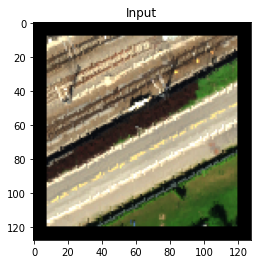

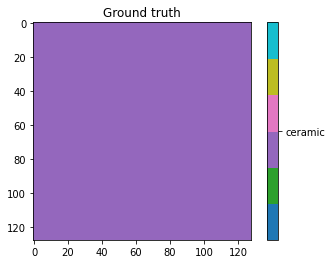

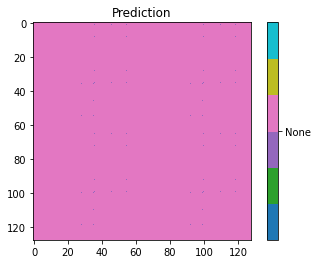

In [47]:
n = 5

plt.imshow(np.dstack([X_test[n,:,:,76], X_test[n,:,:,46], X_test[n,:,:,21]])/2500)
plt.title("Input")
plt.show()

ticks = ["None"]
ticks.extend(['ceramic',
 'concrete',
 'eternit',
 'metal',
 'tar roofing paper'])

colors=mcp.gen_color(cmap="tab10",n=6)
colormap = ListedColormap(colors)

plt.imshow(y_test[n:n+1,:,:,0][0], cmap=colormap)
#cbar = plt.colorbar()
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(ticks)
plt.title("Ground truth")
plt.show()


pred = model.predict(X_test[n:n+1]).argmax(axis=3)[0]
plt.imshow(pred, cmap=colormap)
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(ticks)
plt.title("Prediction")
plt.show()